<a href="https://colab.research.google.com/github/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/03_full_acquisition_simulations/notebooks/Talk2/ESMRMB_ET03_MRzero_to_the_rescue_Going_to_the_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MRzero: Going to the scanner**

In this notebook, MRzero simulation is used to simulate the appearance of N/2 Ghosts in EPI images.

**1. Install and import libraries**

In [1]:
!pip install pypulseq==1.4.2 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [2]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
import os
from google.colab import output
import matplotlib.image as mpimg

plt.rcParams['figure.dpi'] = 100

**2. Prepare scanner**

In [3]:
system = pp.Opts(
    max_grad=80,
    grad_unit='mT/m',
    max_slew=200,
    slew_unit='T/m/s',
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
    adc_dead_time=20e-6,
    grad_raster_time=10e-6
)

**3. Acquisition conditions**

In [4]:
fov, slice_thickness = 200e-3, 8e-3#m
Nread, Nphase = 64, 64

**4. Construct sequence with pypulseq and save**

In [5]:
def aux_check_timing(seq):
  (ok,error_report,) = seq.check_timing()  # Check whether the timing of the sequence is correct
  if ok:
      print("Timing check passed successfully")
  else:
      print("Timing check failed. Error listing follows:")
      [print(e) for e in error_report]

**5. Overall EPI sequence generator and reconstruction**

In [6]:
def EPI_generator_reconstruction(delay_adc_gradient_OG = 0, blip_duration_factor = 1, B1_factor = 0, B0_factor = 0):

  obj_p_copy = phantom.build()

  # =====================
  #     Change phantom
  # =====================
  obj_p.B0 = obj_p_copy.B0 + B0_inhomogeneity*B0_factor
  obj_p.B1 = obj_p_copy.B1 + B1_inhomogeneity*B1_factor

  # =====================
  #    Create sequence
  # =====================
  seq_EPI = pp.Sequence()

  # Define rf events
  rf1, _, _ = pp.make_sinc_pulse(
      flip_angle=90 * np.pi / 180, duration=1e-3,
      slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
      system=system, return_gz=True
  )

  # Define other gradients and ADC events
  adc_duration_OG = 1e-3
  adc_duration = ((adc_duration_OG / Nread)// system.grad_raster_time) * Nread * system.grad_raster_time

  delay_adc_gradient = ((delay_adc_gradient_OG / 1)// system.rf_raster_time) * 1 * system.rf_raster_time

  gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_duration, system=system)
  gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov, flat_time=adc_duration, system=system)
  adc = pp.make_adc(num_samples=Nread, duration=adc_duration, phase_offset=0 * np.pi / 180, delay=gx.rise_time + delay_adc_gradient, system=system)
  gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

  gp_blip = pp.make_trapezoid(channel='y', area=1 / fov, duration=1e-3*blip_duration_factor, system=system)

  seq_EPI.add_block(rf1)
  gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov, duration=1e-3, system=system)
  seq_EPI.add_block(gx_pre, gp)

  for ii in range(0, Nphase//2):
      seq_EPI.add_block(gx,adc)
      seq_EPI.add_block(gp_blip)
      seq_EPI.add_block(gx_,adc)
      seq_EPI.add_block(gp_blip)
  aux_check_timing(seq_EPI)
  seq_EPI.write("EPI.seq")

  # =====================
  #    Simulate signal
  # =====================
  seq0_EPI = mr0.Sequence.import_file('EPI.seq')
  graph_EPI = mr0.compute_graph(seq0_EPI, obj_p, 200, 1e-3)
  signal_EPI = mr0.execute_graph(graph_EPI, seq0_EPI, obj_p)

  # =====================
  #  Image reconstruction
  # =====================
  kspace_EPI = torch.reshape((signal_EPI), (Nphase, Nread)).clone().t()
  kspace_EPI[:,0::2] = torch.flip(kspace_EPI[:,0::2],[0] )[:,:]
  spectrum_EPI = torch.fft.fftshift(kspace_EPI)
  space_EPI = torch.fft.fft2(spectrum_EPI)
  space_EPI = torch.fft.ifftshift(space_EPI)

  return space_EPI


**6. Prepare digital phantom**

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


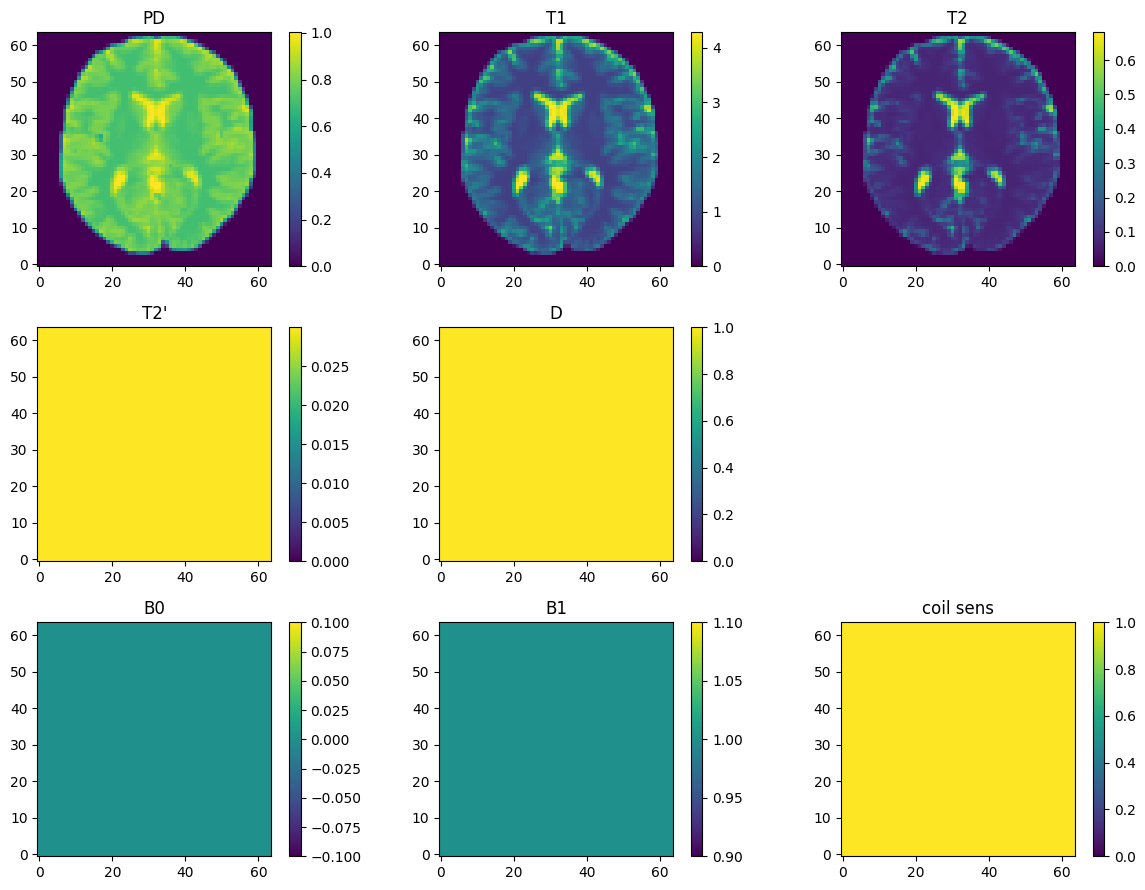

In [7]:
sz = [Nread, Nread]
phantom_inhomogeneity = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
phantom = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
phantom_inhomogeneity = phantom_inhomogeneity.interpolate(sz[0], sz[1], 1)
phantom = phantom.interpolate(sz[0], sz[1], 1)
# Convert Phantom into simulation data
phantom.B0[:] = 0
phantom.B1[:] = 1
obj_p = phantom.build()

obj_p_inhomogeneity = phantom_inhomogeneity.build()
B0_inhomogeneity = obj_p_inhomogeneity.B0
B1_inhomogeneity = obj_p_inhomogeneity.B1

phantom.plot()

**7. Problem #1: Effects of ADC-gradient delay**

Timing check passed successfully
Calculating repetition 1 / 1 - done
Timing check passed successfully
Calculating repetition 1 / 1 - done
Timing check passed successfully
Calculating repetition 1 / 1 - done
Timing check passed successfully
Calculating repetition 1 / 1 - done


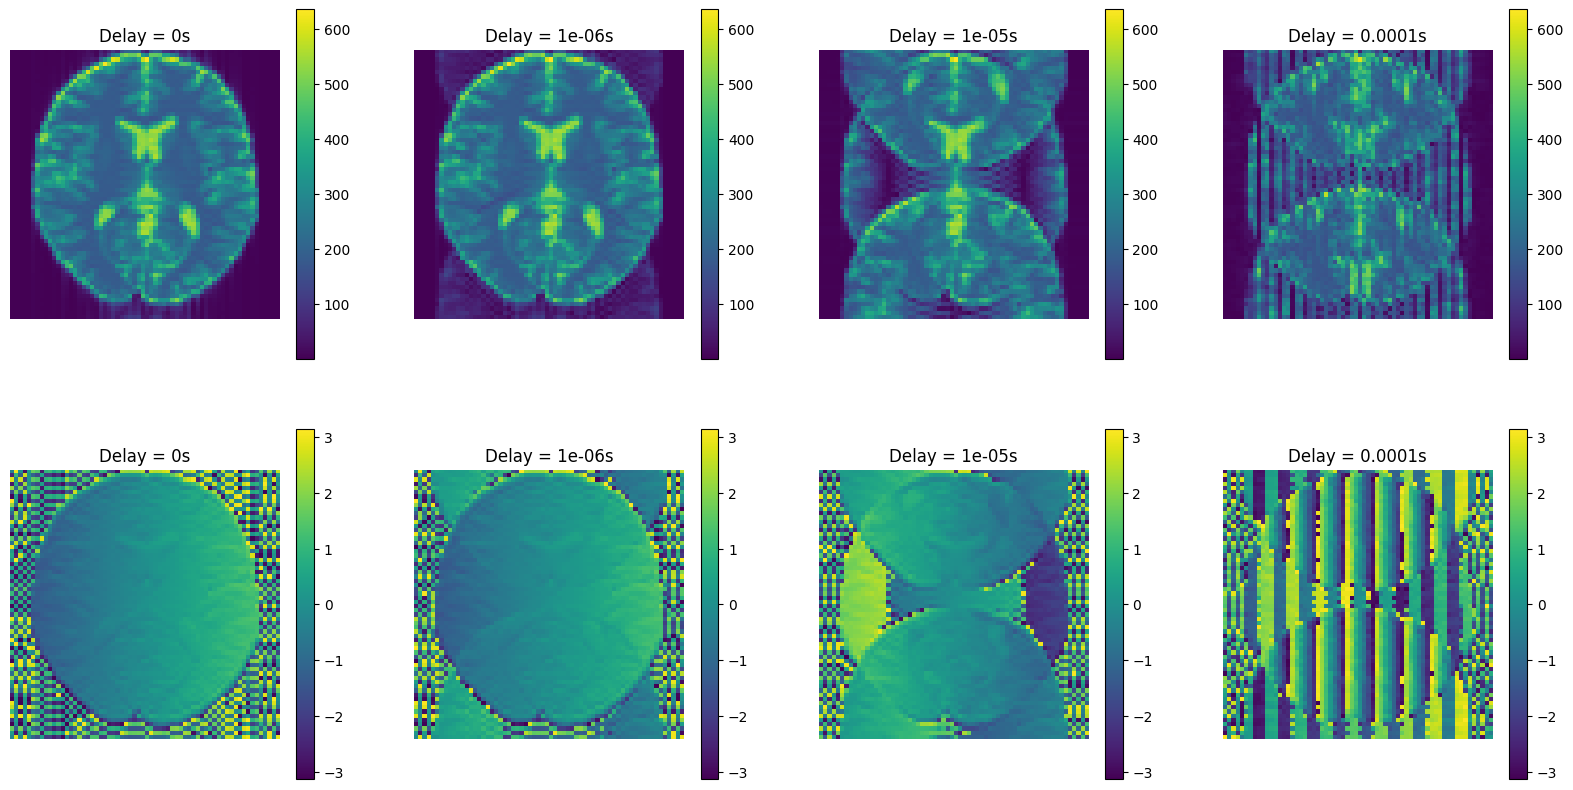

In [8]:
delays = [0, 1e-6, 1e-5, 1e-4]
Ndelays = len(delays)
plt.figure(figsize=[20,10])
counter = 0
for delay in delays:
  counter += 1
  EPI_delay = EPI_generator_reconstruction(delay_adc_gradient_OG = delay)

  if counter == 1:
    min_mag = torch.min(abs(EPI_delay))
    max_mag = torch.max(abs(EPI_delay))

  plt.subplot(2, Ndelays, counter)
  plt.imshow(np.rot90(abs(EPI_delay)), vmin = min_mag, vmax = max_mag)
  plt.title("Delay = " + str(delay) + "s")
  plt.axis("off")
  plt.colorbar()

  plt.subplot(2, Ndelays, counter + Ndelays)
  plt.imshow(np.rot90(np.angle(EPI_delay)), vmin = -np.pi, vmax = np.pi)
  plt.title("Delay = " + str(delay) + "s")
  plt.axis("off")
  plt.colorbar()


**8. Problem #2: Effects of B0**

Timing check passed successfully
Calculating repetition 1 / 1 - done
Timing check passed successfully
Calculating repetition 1 / 1 - done
Timing check passed successfully
Calculating repetition 1 / 1 - done
Timing check passed successfully
Calculating repetition 1 / 1 - done


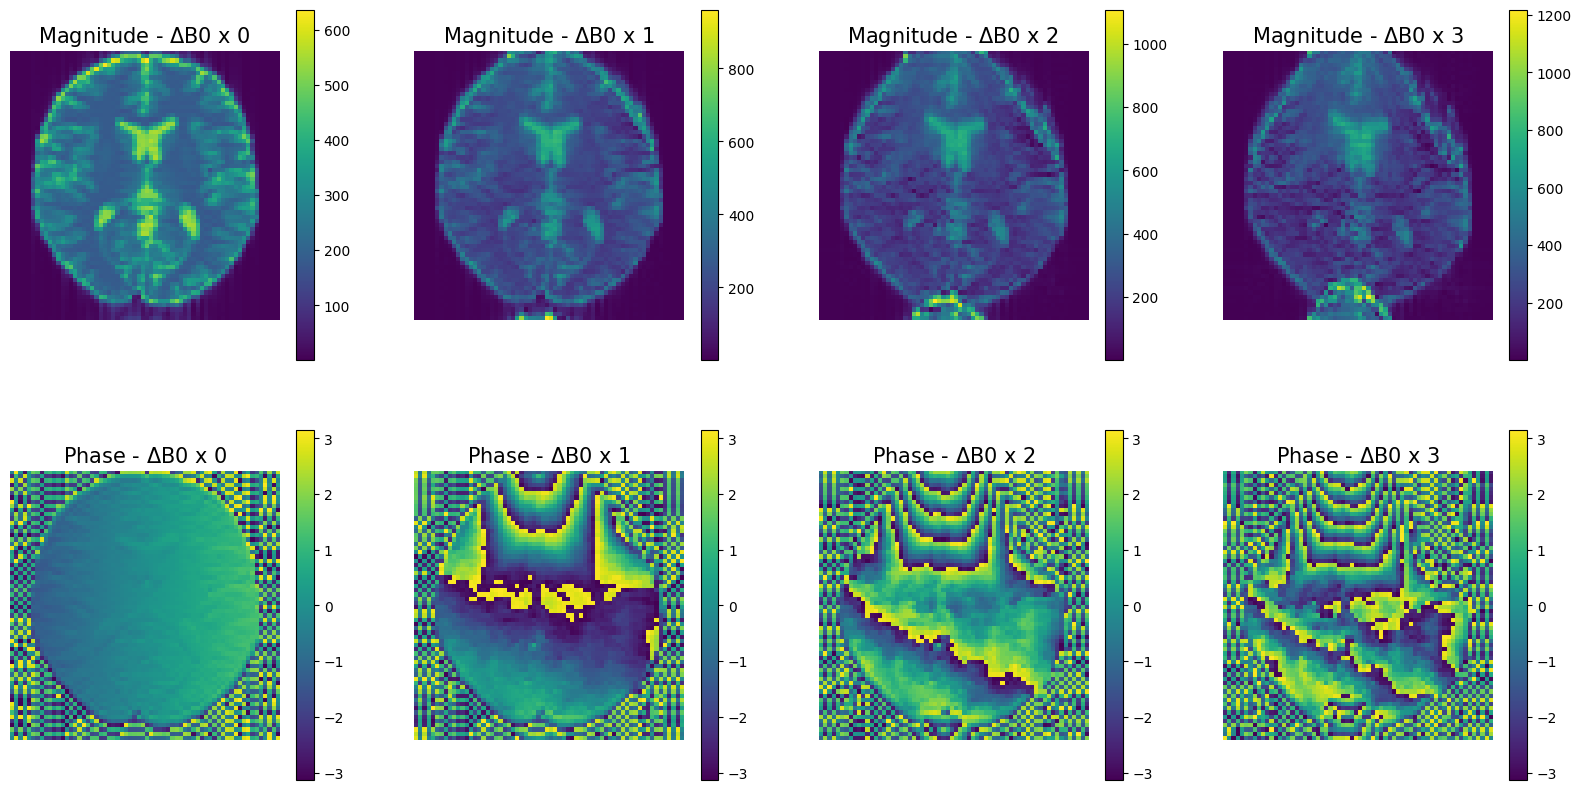

In [9]:
B0_factors = [0, 1, 2, 3]
NB0f = len(B0_factors)
plt.figure(figsize=[20,10])
counter = 0
for B0f in B0_factors:
  counter += 1
  EPI_b0f = EPI_generator_reconstruction(B0_factor = B0f)

  if counter == 1:
    min_mag = torch.min(abs(EPI_b0f))
    max_mag = torch.max(abs(EPI_b0f))

  plt.subplot(2, NB0f, counter)
  plt.imshow(np.rot90(abs(EPI_b0f)))#, vmin = min_mag, vmax = max_mag
  plt.title(r"Magnitude - $\Delta$B0 x " + str(B0f), fontsize = 15)
  plt.axis("off")
  plt.colorbar()

  plt.subplot(2, NB0f, counter + NB0f)
  plt.imshow(np.rot90(np.angle(EPI_b0f)), vmin = -np.pi, vmax = np.pi)
  plt.title(r"Phase - $\Delta$B0 x " + str(B0f), fontsize = 15)
  plt.axis("off")
  plt.colorbar()